<a href="https://colab.research.google.com/github/amankrpandey1/face-emotion-detection-using-cnn-and-opencv/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
<hr>

Humans communicate using facial expressions as well as other body language and verbal cues. Researchers are using deep learning approaches in artificial intelligence research as a way to help make decisions. They need to study people in order to predict how they'll respond or know what they're feeling. This study proposes the development of a system that predicts and classifies facial emotions by using the Convolution Neural Network algorithm, among other features.

Data preprocessing, facial feature extraction, and facial emotion classification are the three key steps in this notebook. Facial expressions were predicted with 62.66% accuracy using the Convolutional Neural Network (CNN). This algorithm was evaluated on a database from [FER2013](https://https://www.kaggle.com/datasets/deadskull7/fer2013) database, which has **35887 48x48** grayscale images representing each of the emotions.

<br>

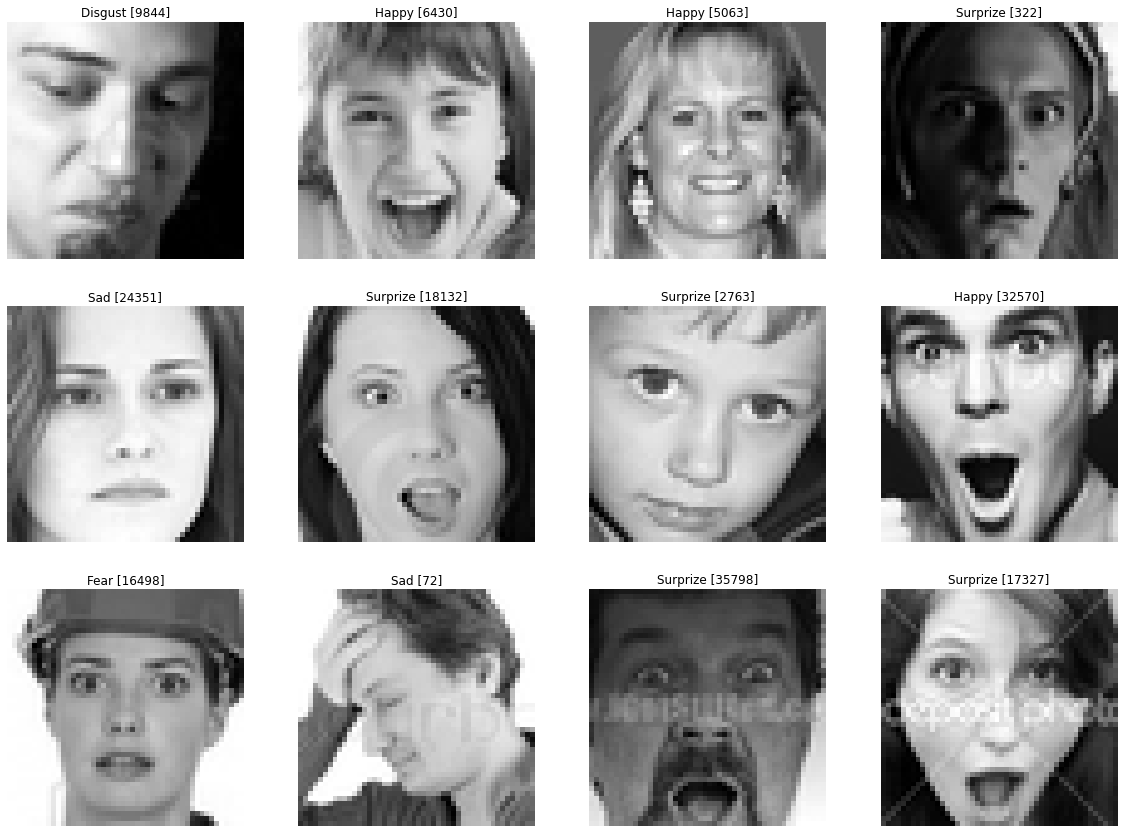

##Here we are also going to use OpenCV for the webcam and model deployement.

#Setting up kaggle api for getting the datset
<hr>

####For that you can go to kaggle.com-> your profile-> Account-> Create New API Token
Then upload the kaggle.json file in google collab and then run the below commands

In [ ]:
# ! pip install kaggle
# ! mkdir ~/.kaggle #creating a hidden directory
# ! cp kaggle.json ~/.kaggle/ #pasting the kaggle api token to above dir
# ! chmod 600 ~/.kaggle/kaggle.json ## chaging the mode for the file

**Put the name of the dataset that you want to use and then unzip the dataset**

In [ ]:
# ! kaggle datasets download deadskull7/fer2013 # downloading the datset

In [ ]:
# ! unzip /content/fer2013.zip #unzip the downloaded dataset

#Importing necesaary files
<hr>



In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement 
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array

In [ ]:
df = pd.read_csv('../data/fer2013.csv') #read dataset

df.head(5),df.shape  #first five rows and count of rows and columns

#Exploraotry Data Analysis
<hr>



In [ ]:
print("Null values present in the file:",df.isna().sum().sum())
print("Basic information about the dataframe:")
df.info()

df.describe()

In [ ]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

##No of images present in dataset corresponding to each emotion

In [ ]:
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

##No of images present in dataset corresponding to training testing and validation part

In [ ]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

##Visualizing images from the dataset

In [ ]:
# from PIL import Image
# pixels = df['pixels'][0]
# b = bytes(int(p) for p in pixels.split())
# i = Image.frombuffer('L',(48,48),b)
# di.save('a.png')
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)

#Data Preprocessing
<hr>

## Extracting rows for each part

In [ ]:
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
y_train = np.array(y_train)
X_test = np.array(X_test,dtype='float')
y_test = np.array(y_test)
X_val = np.array(X_val,dtype='float')
y_val = np.array(y_val)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

**As you can see above we have to change the shape of the images to train them as the above shape is not compatible**

In [ ]:
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0],48,48,1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)

y_train = to_categorical(y_train,num_classes=7) 
y_test = to_categorical(y_test,num_classes=7)
y_val = to_categorical(y_val,num_classes=7)

X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

#Defining Model Archietechture

VGG16

In [ ]:
def cnn_model():
  model = Sequential()

  model.add(ZeroPadding2D((1,1),input_shape=(48,48,1),name="block1_pad1"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l1"))
  model.add(ZeroPadding2D((1,1),name="block1_pad2"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool1"))

  model.add(ZeroPadding2D((1,1),name="block2_pad1"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_l1"))
  model.add(ZeroPadding2D((1,1),name="block2_l2"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_pad2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool2"))

  model.add(ZeroPadding2D((1,1),name="block3_pad1"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l1"))
  model.add(ZeroPadding2D((1,1),name="block3_pad2"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l2"))
  model.add(ZeroPadding2D((1,1),name="block3_pad3"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool3"))

  model.add(ZeroPadding2D((1,1),name="block4_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l1"))
  model.add(ZeroPadding2D((1,1),name="block4_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l2"))
  model.add(ZeroPadding2D((1,1),name="block4_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool4"))


  model.add(ZeroPadding2D((1,1),name="block5_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l1"))
  model.add(ZeroPadding2D((1,1),name="block5_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l2"))
  model.add(ZeroPadding2D((1,1), name="block5_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool5"))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu',name="block6"))
  model.add(Dropout(0.5,name="drop1"))
  model.add(Dense(4096, activation='relu',name="block7"))
  model.add(Dropout(0.5,name="drop2"))
  model.add(Dense(7, activation='softmax',name="block8"))

  return model

In [ ]:
model = cnn_model()
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=32,
#     epochs=30,
#     callbacks=checkpointer,
#     validation_data=(X_val,y_val)
# )

898/898 [==============================] - ETA: 0s - loss: 1.7809 - accuracy: 0.2704
Epoch 2: val_accuracy improved from 0.24937 to 0.26748, saving model to best_model.h5
898/898 [==============================] - 1257s 1s/step - loss: 1.7809 - accuracy: 0.2704 - val_loss: 2.0771 - val_accuracy: 0.2675
Epoch 3/30
898/898 [==============================] - ETA: 0s - loss: 1.6207 - accuracy: 0.3589
Epoch 3: val_accuracy improved from 0.26748 to 0.28476, saving model to best_model.h5
898/898 [==============================] - 421s 469ms/step - loss: 1.6207 - accuracy: 0.3589 - val_loss: 1.7818 - val_accuracy: 0.2848
Epoch 4/30
898/898 [==============================] - ETA: 0s - loss: 1.4953 - accuracy: 0.4184
Epoch 4: val_accuracy improved from 0.28476 to 0.39287, saving model to best_model.h5
898/898 [==============================] - 427s 475ms/step - loss: 1.4953 - accuracy: 0.4184 - val_loss: 1.5432 - val_accuracy: 0.3929
Epoch 5/30
898/898 [==============================] - ETA: 0s 

#Model Evaluation
<hr>

Lets see the output resutls <br>
* Loss plot
* Images with their predicted vs actual label
* Confusion Matrix
* Classification Reprot

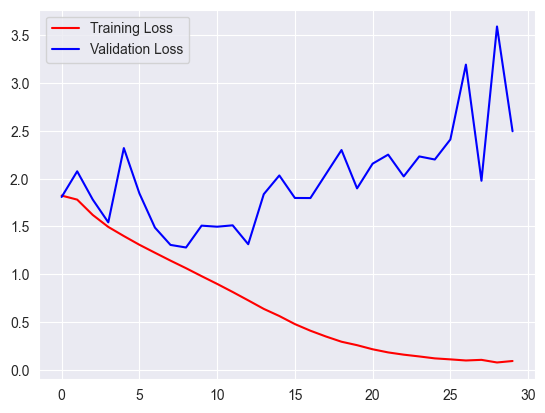

In [ ]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

In [ ]:
# Model Inference
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 15s 132ms/step


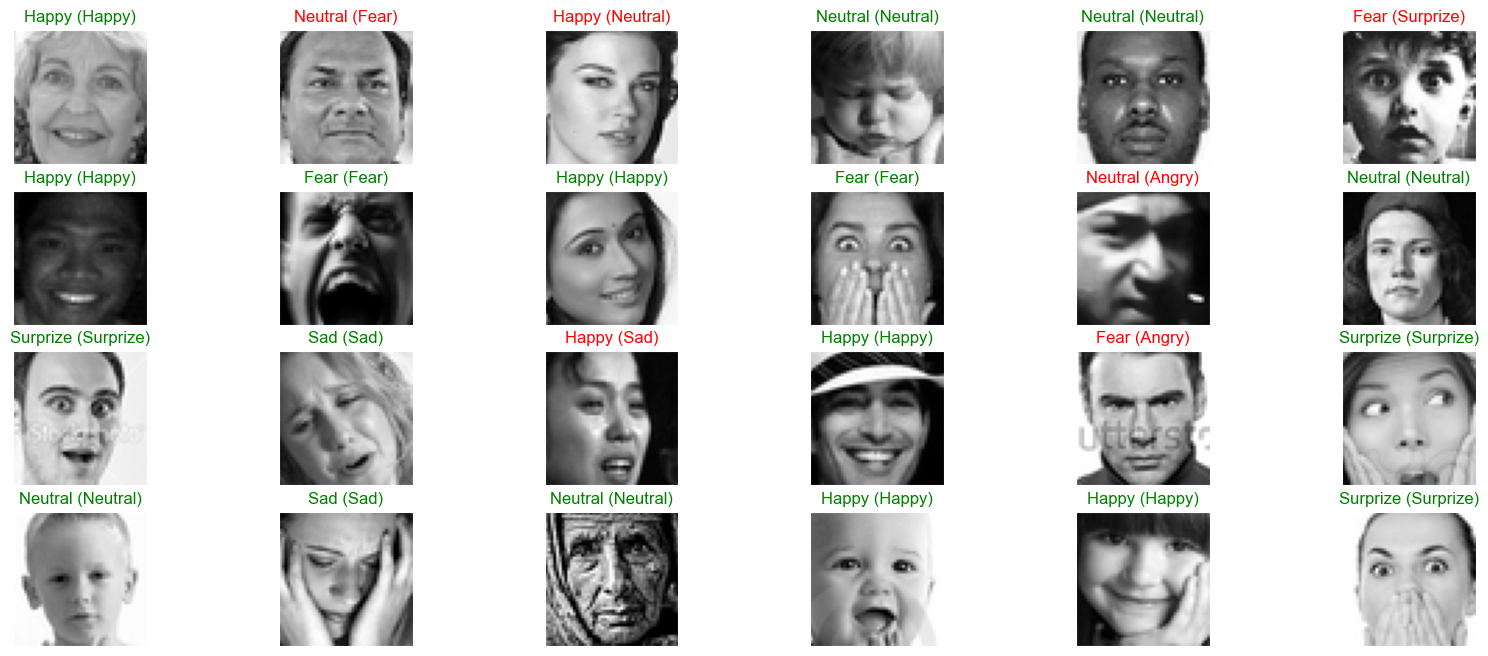

In [ ]:
#function to plot images with their lables(actual vs predicted)
def check_images(X_test,y_pred,label_dict={}):

  figure = plt.figure(figsize=(20, 8))
  for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
      ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(X_test[index]),cmap="gray")
      predict_index = label_dict[(y_pred[index])]
      true_index = label_dict[np.argmax(y_test,axis=1)[index]]
      
      ax.set_title("{} ({})".format((predict_index), 
                                    (true_index)),
                                    color=("green" if predict_index == true_index else "red"))
check_images(X_test,y_pred,emotions)

In [ ]:
# function to plot confusion matrix
def conf_mat(y_test,y_pred,labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]):
  CLASS_LABELS  = labels
  cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (20,10))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

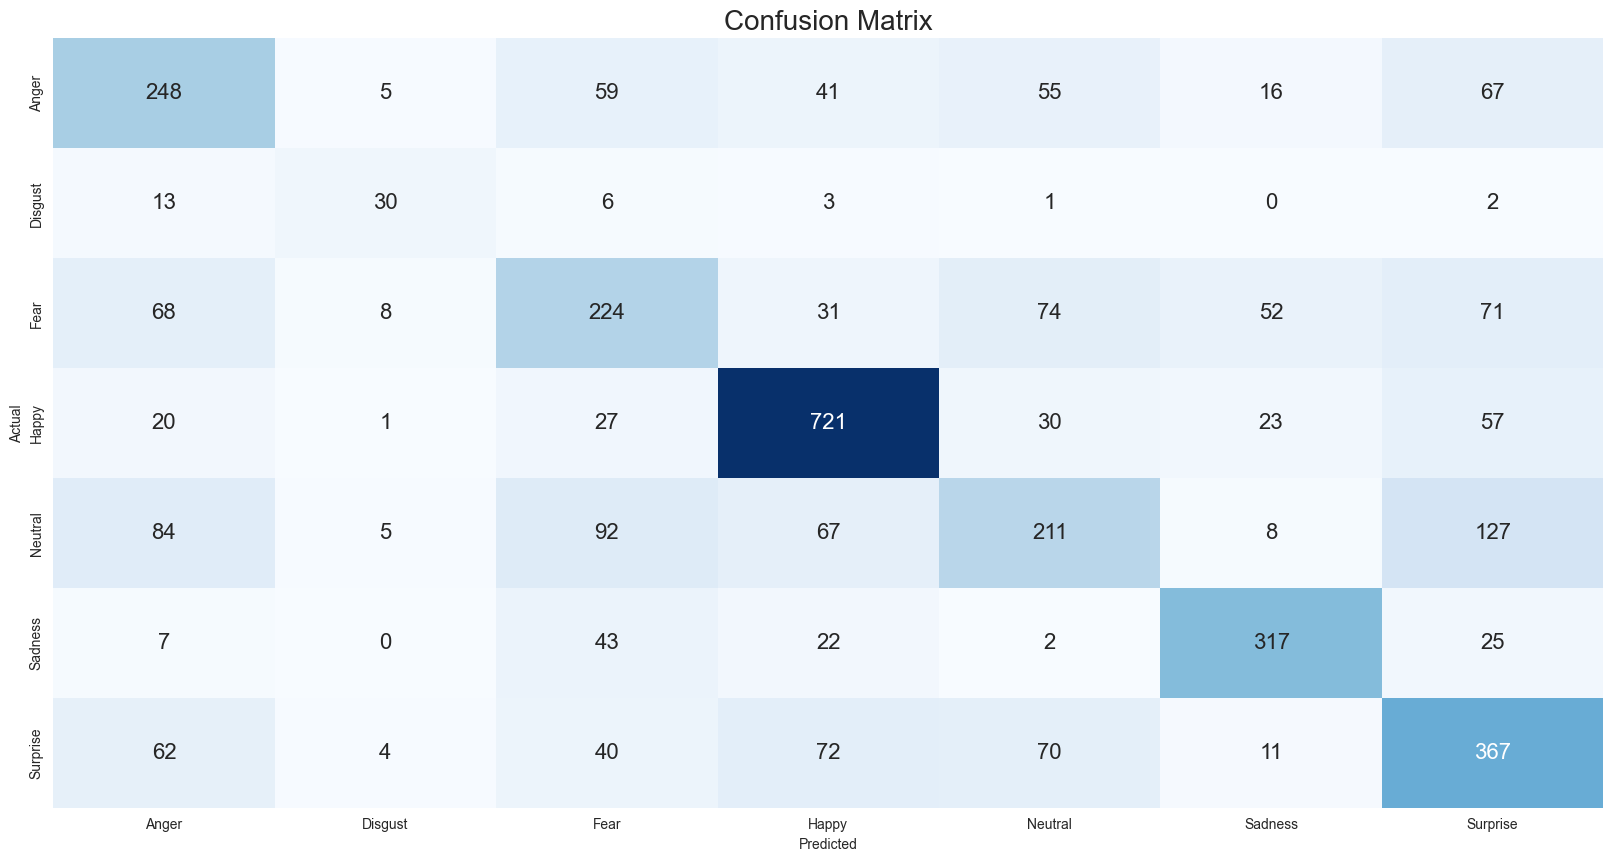

In [ ]:
conf_mat(y_test,y_pred)

In [ ]:
#classification report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.494     0.505     0.499       491
           1      0.566     0.545     0.556        55
           2      0.456     0.424     0.440       528
           3      0.753     0.820     0.785       879
           4      0.476     0.355     0.407       594
           5      0.742     0.762     0.752       416
           6      0.513     0.586     0.547       626

    accuracy                          0.590      3589
   macro avg      0.572     0.571     0.569      3589
weighted avg      0.582     0.590     0.584      3589



In [ ]:
 # loss and accuracy
loss_and_metrics = model.evaluate(X_train,y_train)
print("On Training Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_val,y_val)
print("On Validation Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_test,y_test)
print("On Test Data",loss_and_metrics)


898/898 [==============================] - 119s 133ms/step - loss: 0.0449 - accuracy: 0.9860
On Training Data [0.04489957168698311, 0.986032247543335]
113/113 [==============================] - 15s 131ms/step - loss: 2.4962 - accuracy: 0.5871
On Validation Data [2.4961748123168945, 0.5870715975761414]
113/113 [==============================] - 14s 127ms/step - loss: 2.5014 - accuracy: 0.5901
On Test Data [2.5013692378997803, 0.5901365280151367]


#Fine Tuning
<hr>

Let's try to improve the model

##1. Changing epoch, learning rate and batch size

In [ ]:
# model = cnn_model()
# model.compile(optimizer=SGD(learning_rate=0.005),loss='categorical_crossentropy',metrics=['accuracy'])
#
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=64,
#     epochs=60,
#     callbacks=checkpointer,
#     validation_data=(X_val,y_val)
# )


Epoch 1/60
 47/449 [==>...........................] - ETA: 5:39 - loss: 1.8982 - accuracy: 0.2074

KeyboardInterrupt: 

In [ ]:
loss_plot(history)

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

##2. Changing optimizer

In [ ]:
# # loss and accuracy
#
# model = cnn_model()
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
#
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=64,
#     epochs=50,
#     callbacks=checkpointer,
#     validation_data=(X_val,y_val)
# )


In [ ]:
loss_plot(history)

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

#Observation

Seems like the model is getting overfitted by the data and the same arch. is not giving better results after tuning.
More steps that can be taken to improve the performance
1. Adding regularization in the model Arch.
2. Adding more data in validation set
3. Try with diff cnn arch

#Model Saving

In [30]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
# model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


#Deploying model using OpenCV
<hr>

Note: Run the below code in your local machine

##loading model arch and weights

In [3]:
model = model_from_json(open("../models/model.json", "r").read())
model.load_weights('../models/best_model.h5')
face_haar_cascade = cv2.CascadeClassifier('../models/haarcascade_frontalface_default.xml')

##Open CV code for webcam and prediction

In [ ]:
# cap=cv2.VideoCapture(0) # start webcam
# while True:
#     (valid,test_image)=cap.read() #reading image from video frame
#     if not valid: #if not getting frames then exit
#         break
#
#     gray_image= cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) #converting the rgb image to grayscale
#
#
#     faces_detected = face_haar_cascade.detectMultiScale(gray_image) #detecting faces from the image using haar_cascade
#     for (x,y,w,h) in faces_detected: #cordinates of deteced faces
#         cv2.rectangle(gray_image,(x,y), (x+w,y+h), (255,0,0)) #putting a rectange box around detected face
#         roi_gray=gray_image[y:y+w,x:x+h]  # capturing only face from the image
#         roi_gray=cv2.resize(roi_gray,(48,48)) # resizing it to 48,48 (that's what mdodel wants as an input)
#         image_pixels = img_to_array(roi_gray) #converting image to array
#         image_pixels = np.expand_dims(image_pixels, axis = 0) #expanding dims as model needs input in batches
#         # image_pixels /= 255
#
#
#         predictions = model.predict(image_pixels) #model prediction
#         max_index = np.argmax(predictions[0]) #getting emotion index
#
#         emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
#         emotion_prediction = emotion_detection[max_index]
#
#
#         cv2.putText(test_image, emotion_prediction, (int(x), int(y)),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3) #putting text around face
#     #   cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
#
#
#         resize_image = cv2.resize(test_image, (1000, 700)) #enhancing the image to display
#         cv2.imshow('Emotion Dectector',resize_image)
#         if cv2.waitKey(10) == ord('b'):
#             break
# cap.release()
# cv2.destroyAllWindows

1/1 [==============================] - 0s 39ms/step


In [8]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.models import load_model


image_path = "../depositphotos_192398186-stock-photo-beautiful-angry-woman-makeup-white.jpg"

test_image = cv2.imread(image_path)
# plt.imshow(test_image)
# read the image from file path
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)  # convert the rgb image to grayscale
# plt.imshow(gray_image)
faces_detected = face_haar_cascade.detectMultiScale(gray_image)  # detect faces from the image using haar_cascade
#
# plt.imshow(faces_detected)
for (x, y, w, h) in faces_detected:  # coordinates of detected faces
    cv2.rectangle(test_image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # put a rectangle box around detected face

    roi_gray = gray_image[y:y + h, x:x + w]  # capture only the face from the image
    roi_gray = cv2.resize(roi_gray, (48, 48))  # resize it to 48x48 (that's what the model wants as an input)
    image_pixels = img_to_array(roi_gray)  # convert image to array
    image_pixels = np.expand_dims(image_pixels, axis=0)  # expand dims as the model needs input in batches

    predictions = model.predict(image_pixels)  # model prediction
    max_index = np.argmax(predictions[0])  # get the emotion index

    emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    emotion_prediction = emotion_detection[max_index]
    print(emotion_prediction)

    cv2.putText(test_image, emotion_prediction, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)  # put text around face

resize_image = cv2.resize(test_image, (1000, 700))  # enhance the image to display
# cv2.imshow('Emotion Detector', resize_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
